This notebook provides an example of the fituning experiment to verify the benefit brought by a larger learning rate is not solely from the improved performance of end models.

In [ ]:
import sys
sys.path.append("..")

In [ ]:
import torch
from source.utils.utils import load_model
from source.utils.data_funcs import load_data
from source.utils.logger import Logger
from source.utils.train import train
from source.utils.weight_matching import weight_matching
from source.utils.activation_matching import activation_matching
from source.utils.connect import eval_line
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy

In [ ]:
class config:
    model = 'cifar_resnet20'
    dataset = 'cifar10'
    special_init = None # 'vgg_init' (kaiming init) or None (uniform init)
    print_freq = 100
    data_dir = '../../Linear_Mode_Connectivity/data'
    n = 3 # number of interpolation points

In [ ]:
# necessary to create logger if using the train/validate/eval_line etc. functions
Logger.setup_logging()
logger = Logger()

trainset, testset = load_data(config.data_dir, config.dataset)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=256, shuffle=False)

trainset_noaug, _ = load_data(config.data_dir, config.dataset, no_random_aug=True)
trainloader_noaug = DataLoader(trainset_noaug, batch_size=128, shuffle=True)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
sd_large_1 = torch.load(f'../../Linear_Mode_Connectivity/same_init_ex/{config.dataset}/{config.model}/diff_init/seed_10/model_1_160.pt', map_location=device)
sd_large_2 = torch.load(f'../../Linear_Mode_Connectivity/same_init_ex/{config.dataset}/{config.model}/diff_init/seed_10/model_2_160.pt', map_location=device)

model_large_1 = load_model(config).to(device)
model_large_2 = load_model(config).to(device)
model_large_1.load_state_dict(sd_large_1)
model_large_2.load_state_dict(sd_large_2)

In [ ]:
model_large_1_ft = deepcopy(model_large_1)
model_large_2_ft = deepcopy(model_large_2)

In [ ]:
optimizer_large_1_ft = torch.optim.SGD(model_large_1_ft.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
optimizer_large_2_ft = torch.optim.SGD(model_large_2_ft.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
for epoch in range(1):
    train(trainloader, model_large_1_ft, criterion, optimizer_large_1_ft, 0, device, config)
    train(trainloader, model_large_2_ft, criterion, optimizer_large_2_ft, 0, device, config)

In [ ]:
sd_large_2_ft_wm, _ = weight_matching(config.model, model_large_1_ft.state_dict(), model_large_2_ft.state_dict(), device=device)
sd_large_2_ft_am, _ = activation_matching(config.model, model_large_1_ft, model_large_2_ft, trainloader, 100, device)

model_large_2_ft_wm = load_model(config).to(device)
model_large_2_ft_wm.load_state_dict(sd_large_2_ft_wm)
model_large_2_ft_am = load_model(config).to(device)
model_large_2_ft_am.load_state_dict(sd_large_2_ft_am)

In [ ]:
test_lmc_large_lr_ft_wm = eval_line(model_large_1_ft, model_large_2_ft_wm, testloader, criterion, device, config, bn_loader=trainloader, reset_bn=True, n=config.n)
test_lmc_large_lr_ft_am = eval_line(model_large_1_ft, model_large_2_ft_am, testloader, criterion, device, config, bn_loader=trainloader, reset_bn=True, n=config.n)

In [ ]:
sd_small_1 = torch.load(f'../../Linear_Mode_Connectivity/same_init_ex/{config.dataset}/{config.model}/diff_init/seed_10_lr_0.01/model_1_160.pt', map_location=device)
sd_small_2 = torch.load(f'../../Linear_Mode_Connectivity/same_init_ex/{config.dataset}/{config.model}/diff_init/seed_10_lr_0.01/model_2_160.pt', map_location=device)

model_small_1 = load_model(config).to(device)
model_small_2 = load_model(config).to(device)
model_small_1.load_state_dict(sd_small_1)
model_small_2.load_state_dict(sd_small_2)

In [ ]:
sd_small_2_wm, _ = weight_matching(config.model, sd_small_1, sd_small_2, device=device)
sd_small_2_am, _ = activation_matching(config.model, model_small_1, model_small_2, trainloader, 100, device)

model_small_2_wm = load_model(config).to(device)
model_small_2_wm.load_state_dict(sd_small_2_wm)
model_small_2_am = load_model(config).to(device)
model_small_2_am.load_state_dict(sd_small_2_am)

In [ ]:
test_lmc_small_lr_wm = eval_line(model_small_1, model_small_2_wm, testloader, criterion, device, config, bn_loader=trainloader, reset_bn=True, n=config.n)
test_lmc_small_lr_am = eval_line(model_small_1, model_small_2_am, testloader, criterion, device, config, bn_loader=trainloader, reset_bn=True, n=config.n)

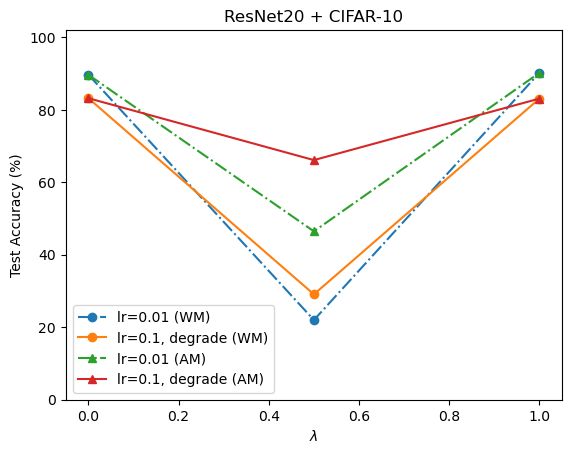

In [28]:
metric = 'acc' # loss acc
title = f'ResNet20 + CIFAR-10'

x_s = np.linspace(0, 1, config.n)
idx = 1 if metric == 'acc' else 0

plt.plot(x_s, test_lmc_small_lr_wm[:, idx], label='lr=0.01 (WM)', marker = 'o', linestyle='-.')
plt.plot(x_s, test_lmc_large_lr_ft_wm[:, idx], label='lr=0.1, degrade (WM)', marker = 'o')
plt.plot(x_s, test_lmc_small_lr_am[:, idx], label='lr=0.01 (AM)', marker = '^', linestyle='-.')
plt.plot(x_s, test_lmc_large_lr_ft_am[:, idx], label='lr=0.1, degrade (AM)', marker = '^')

plt.title(title)
plt.ylabel('Test Accuracy (%)')
plt.ylim(0, 102)
plt.xlabel(r'$\lambda$')

plt.legend()